# 캐글 Advanced 머신러닝 실전 박치기 연습

In [2]:
import numpy as np
import pandas as pd
import gc
import time
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

In [3]:
default_data_dir = './data/'
app_train = pd.read_csv(os.path.join(default_data_dir, 'application_train.csv'))
app_test = pd.read_csv(os.path.join(default_data_dir, 'application_test.csv'))

### TARGET 값 분포 및 AMT_INCOME_TOTAL 값 Histogram
 * TARGET 값별 분포도를 pandas, matplotlib, seaborn을 통한 Histogram 표현

In [51]:
# 값 개수 보기
# app_train['TARGET'].value_counts()
# 백분율로 보기
# app_train['TARGET'].value_counts() / app_train.shape[0]

<AxesSubplot:>

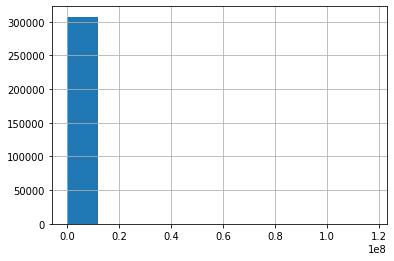

In [52]:
app_train['AMT_INCOME_TOTAL'].hist()

### AMT_INCOME_TOTAL 이 100000 이하인 값에 대한 분포도 그래프

<AxesSubplot:>

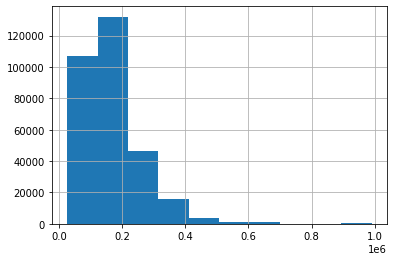

In [53]:
app_train[app_train['AMT_INCOME_TOTAL'] < 1000000]['AMT_INCOME_TOTAL'].hist()

(array([1.07232e+05, 1.32012e+05, 4.62030e+04, 1.57320e+04, 3.63400e+03,
        1.09300e+03, 8.67000e+02, 1.62000e+02, 1.24000e+02, 2.02000e+02]),
 array([ 25650., 122085., 218520., 314955., 411390., 507825., 604260.,
        700695., 797130., 893565., 990000.]),
 <BarContainer object of 10 artists>)

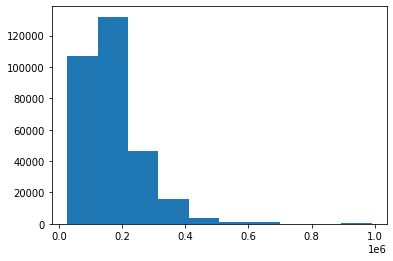

In [54]:
plt.hist(app_train[app_train['AMT_INCOME_TOTAL'] < 1000000]['AMT_INCOME_TOTAL'])

/home/lmu/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='AMT_INCOME_TOTAL', ylabel='Density'>

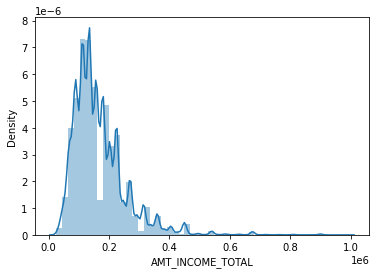

In [55]:
sns.distplot(app_train[app_train['AMT_INCOME_TOTAL'] < 1000000]['AMT_INCOME_TOTAL'])

/home/lmu/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='AMT_INCOME_TOTAL', ylabel='Density'>

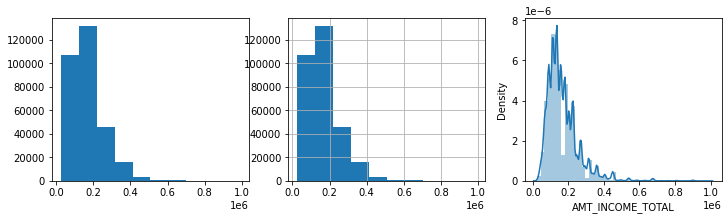

In [56]:
displayed_data = app_train[app_train['AMT_INCOME_TOTAL'] < 1000000]['AMT_INCOME_TOTAL']
fig, axs = plt.subplots(figsize=(12, 3), nrows=1, ncols=3, squeeze=False)
axs[0][0].hist(displayed_data)
displayed_data.hist(ax=axs[0][1])
sns.distplot(displayed_data, ax=axs[0][2])

### TARGET 값에 따른 AMT_INCOME_TOTAL 값 분포도 비교
 * `distplot`와 `violinplot` 으로 시각화

/home/lmu/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/lmu/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='AMT_INCOME_TOTAL', ylabel='Density'>

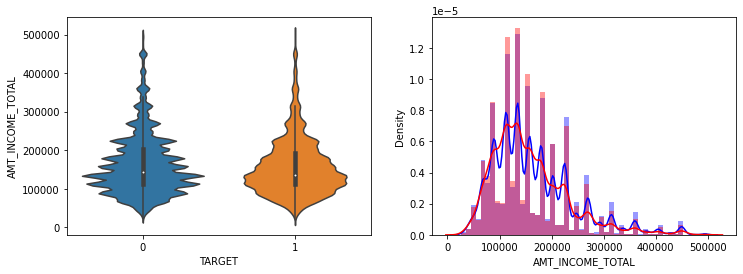

In [57]:
cond0 = (app_train['TARGET'] == 0)
cond1 = (app_train['TARGET'] == 1)
mnt_threshold = 500000
cond_mnt = (app_train['AMT_INCOME_TOTAL'] < mnt_threshold)

fig, axs = plt.subplots(figsize=(12, 4), nrows=1, ncols=2, squeeze=False)
sns.violinplot(x='TARGET', y='AMT_INCOME_TOTAL', data=app_train[cond_mnt], ax=axs[0][0])
sns.distplot(app_train[cond0 & cond_mnt]['AMT_INCOME_TOTAL'], ax=axs[0][1], color='blue')
sns.distplot(app_train[cond1 & cond_mnt]['AMT_INCOME_TOTAL'], ax=axs[0][1], color='red')

## 기본 학습 모델
### 학습을 위해 categorical column을 label encoding 해주자

In [62]:
apps = pd.concat([app_train, app_test])

In [63]:
object_columns = apps.dtypes[apps.dtypes == 'object'].index.tolist()
for column in object_columns:
    apps[column] = pd.factorize(apps[column])[0]
apps = apps.fillna(-999)

app_train = apps[apps['TARGET'] != -999]
app_test = apps[apps['TARGET'] == -999]
app_test = app_test.drop(['TARGET'], axis=1, inplace=False)

In [28]:
ftr_app = app_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
target_app = app_train['TARGET']

In [29]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(ftr_app, target_app, test_size=.3, random_state=2020)

In [30]:
train_x.shape, valid_x.shape

((215257, 120), (92254, 120))

In [33]:
from lightgbm import LGBMClassifier

clf = LGBMClassifier(
    n_jobs=-1,
    n_estimators=1000,
    learning_rate=.02,
    num_leaves=32,
    subsample=.8,
    max_depth=12,
    silent=-1,
    verbose=-1
)

In [34]:
clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric = 'auc',
       verbose=100, early_stopping_rounds=50)

Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.752205	training's binary_logloss: 0.250372	valid_1's auc: 0.744317	valid_1's binary_logloss: 0.251593
[200]	training's auc: 0.771473	training's binary_logloss: 0.243554	valid_1's auc: 0.754053	valid_1's binary_logloss: 0.247539
[300]	training's auc: 0.784885	training's binary_logloss: 0.239292	valid_1's auc: 0.757737	valid_1's binary_logloss: 0.246203
[400]	training's auc: 0.796336	training's binary_logloss: 0.235948	valid_1's auc: 0.758946	valid_1's binary_logloss: 0.245732
[500]	training's auc: 0.806016	training's binary_logloss: 0.233017	valid_1's auc: 0.759411	valid_1's binary_logloss: 0.24555
Early stopping, best iteration is:
[532]	training's auc: 0.808934	training's binary_logloss: 0.232125	valid_1's auc: 0.759548	valid_1's binary_logloss: 0.245494


LGBMClassifier(learning_rate=0.02, max_depth=12, n_estimators=1000,
               num_leaves=32, silent=-1, subsample=0.8, verbose=-1)

### Feature Importances 시각화

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

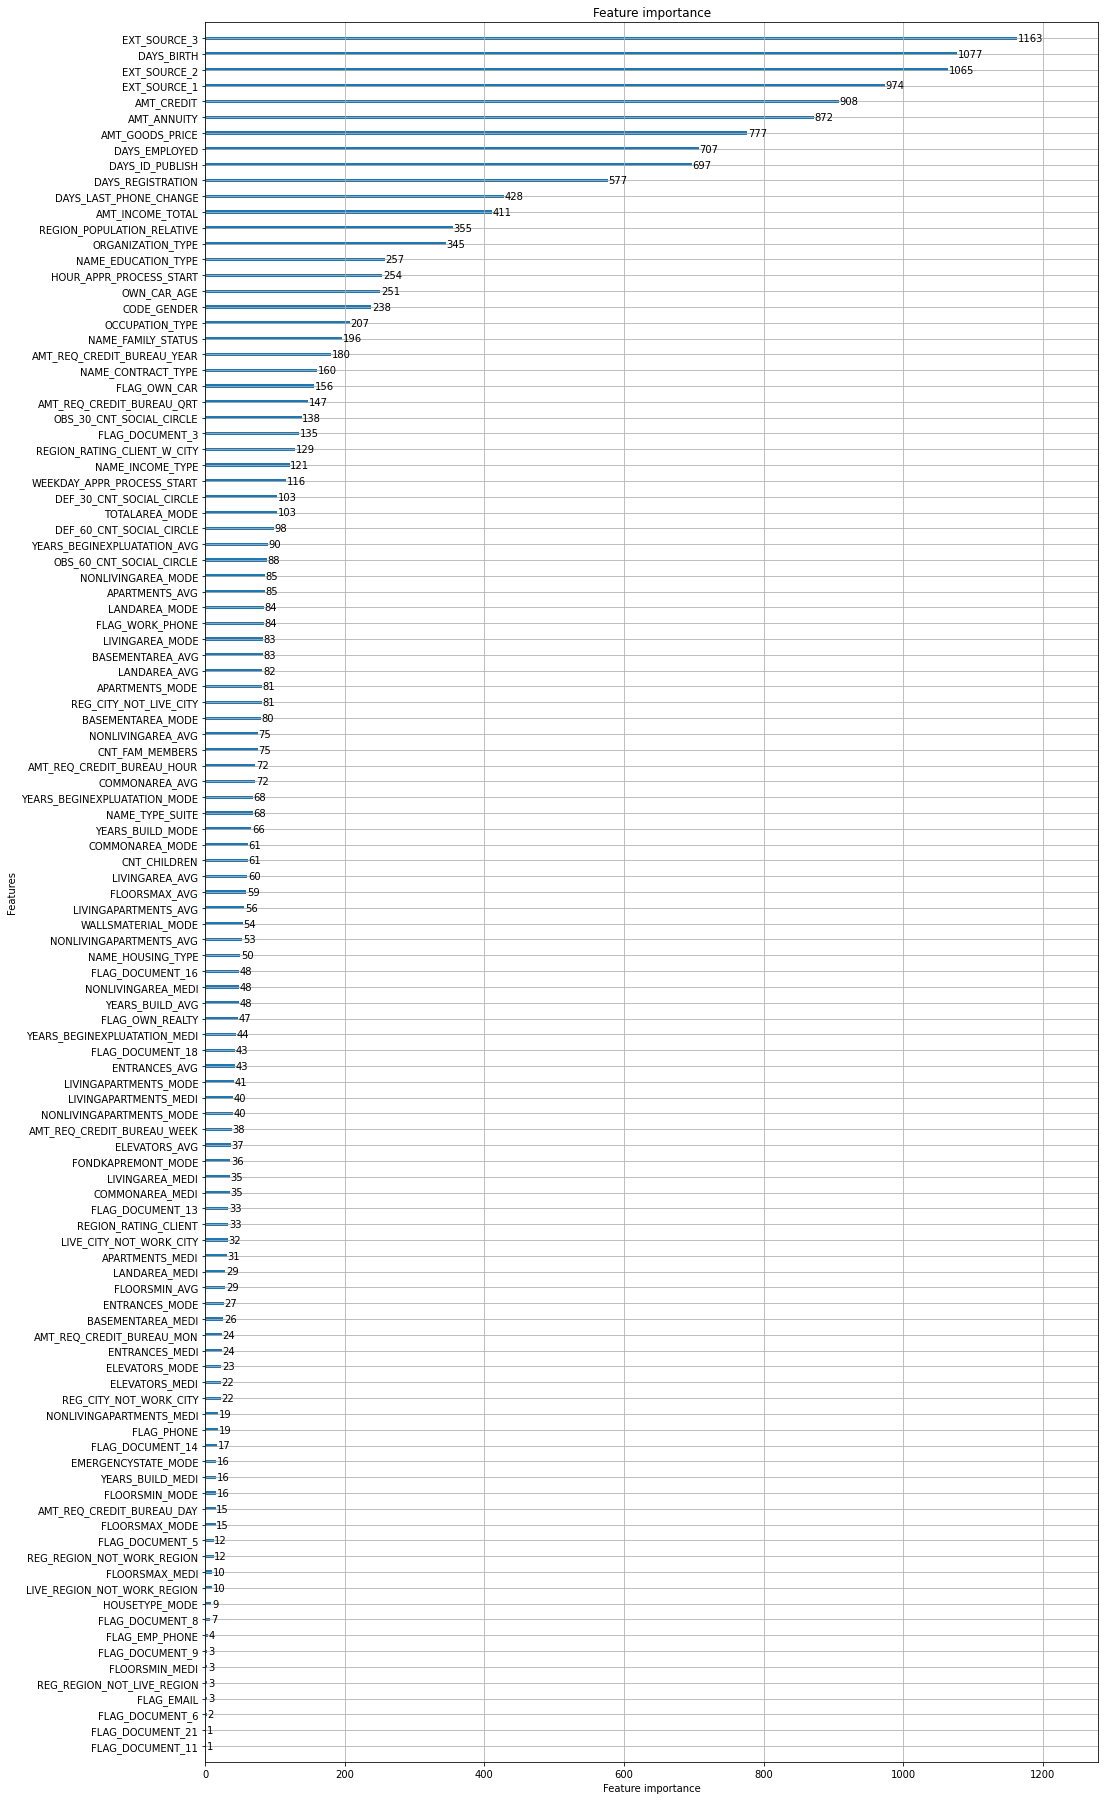

In [36]:
from lightgbm import plot_importance

plot_importance(clf, figsize=(16, 32))

### 학습된 Classifier를 이용하여 테스트 데이터를 예측하고 결과를 Kaggle로 Submit 수행

In [65]:
preds = clf.predict_proba(app_test.drop(['SK_ID_CURR'], axis=1))[:, 1]
app_test['TARGET'] = preds

In [67]:
default_output_dir = './output'
app_test[['SK_ID_CURR', 'TARGET']].to_csv(
    os.path.join(default_output_dir, 'app_baseline_01.csv'),
    index=False)

In [46]:
app_test.drop(['SK_ID_CURR', 'TARGET'], axis=1).shape

(48744, 120)

### Kaggle 에 이대로 제출할 때 0.744 정도의 정확도

## application 데이터 세트에 다양한 feature engineering
 * application_train(test) 주요 feature값들의 분포도 등의 EDA
 * feature engineering

In [68]:
default_data_dir = './data/'
app_train = pd.read_csv(os.path.join(default_data_dir, 'application_train.csv'))
app_test = pd.read_csv(os.path.join(default_data_dir, 'application_test.csv'))

### 주요 feature에 대해서 target마다의 histogram

In [78]:
columns = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY','AMT_GOODS_PRICE', 'DAYS_BIRTH',
           'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'DAYS_REGISTRATION', 'DAYS_LAST_PHONE_CHANGE',
          'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
          'EXT_SOURCE_3', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
          'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
          'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']

In [74]:
def show_hist_by_target(df, columns):
    cond_0 = (df['TARGET'] == 0)
    cond_1 = (df['TARGET'] == 1)
    
    for column in columns:
        fig, axs = plt.subplots(figsize=(12, 4), nrows=1, ncols=2, squeeze=False)
        sns.violinplot(x='TARGET', y=column, data=df, ax=axs[0][0])
        sns.distplot(df[cond_1][column], label='1', color='red', ax=axs[0][1])
        sns.distplot(df[cond_0][column], label='0', color='blue', ax=axs[0][1])

/home/lmu/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/lmu/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/lmu/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an ax

/home/lmu/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/lmu/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/lmu/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an ax

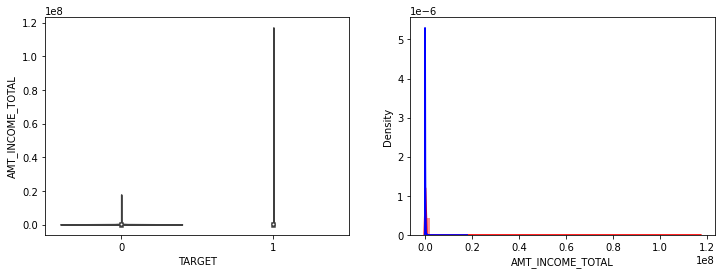

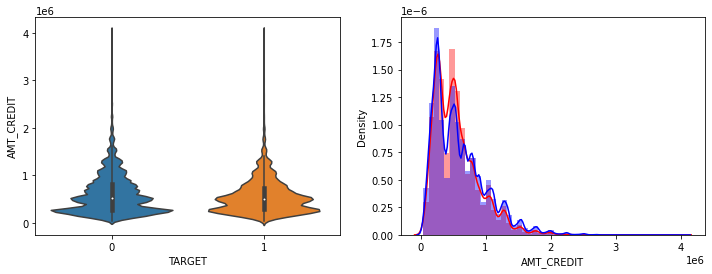

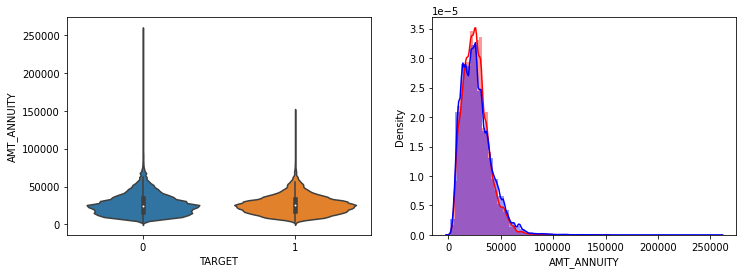

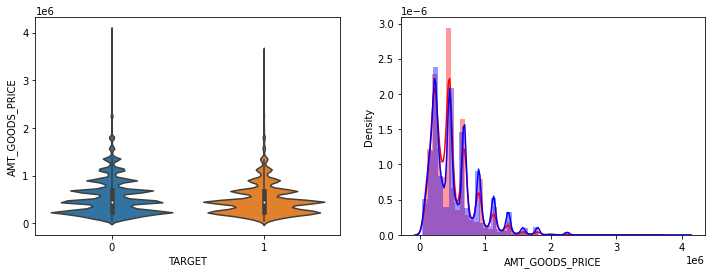

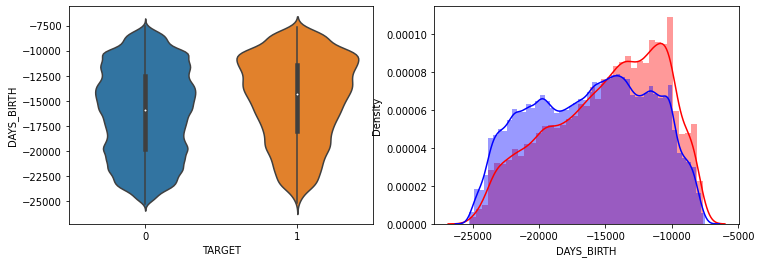

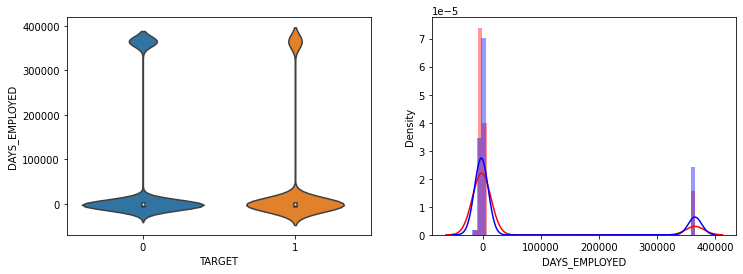

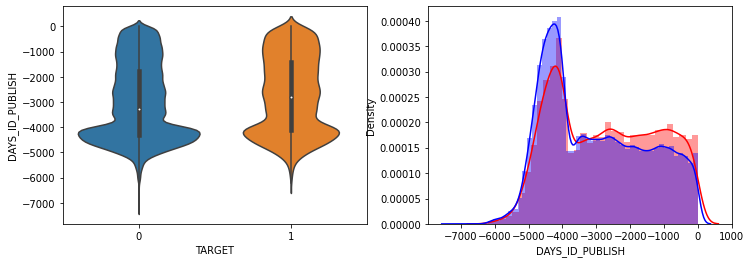

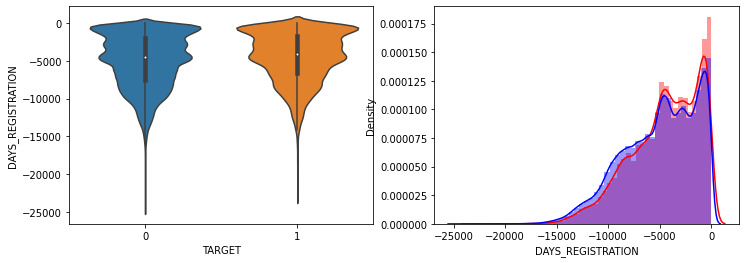

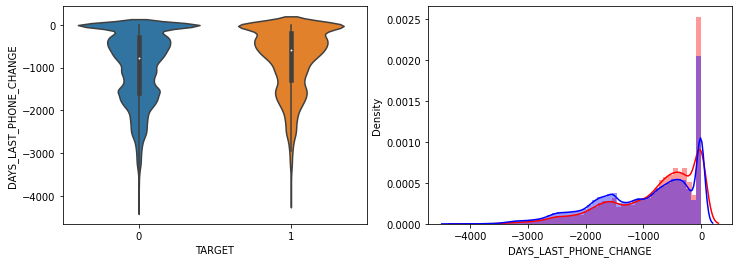

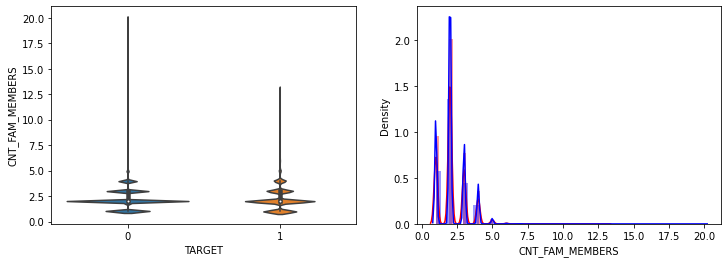

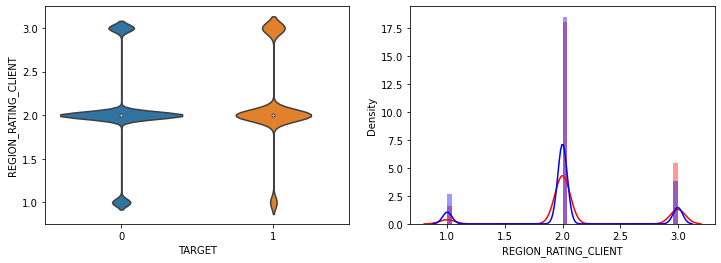

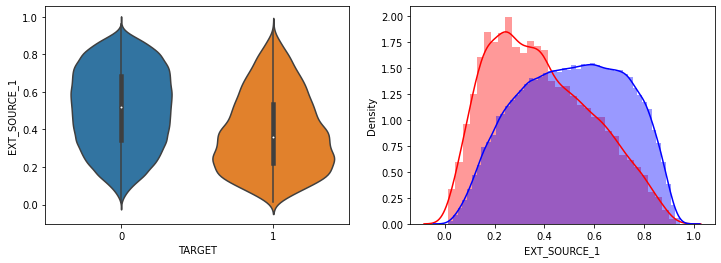

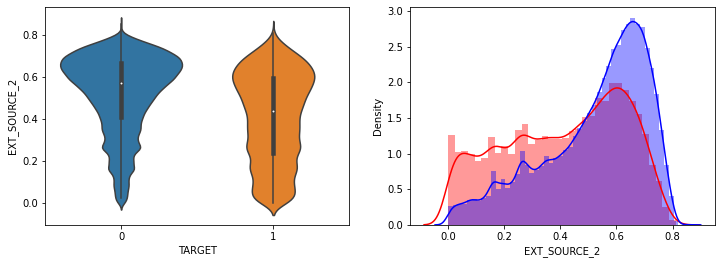

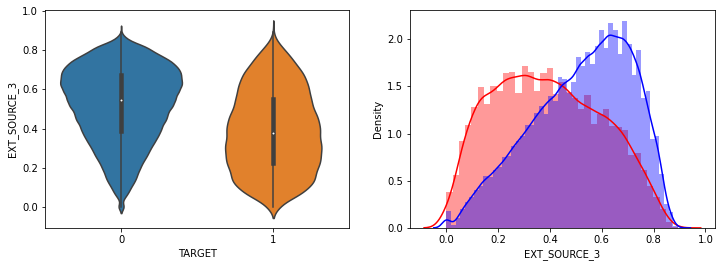

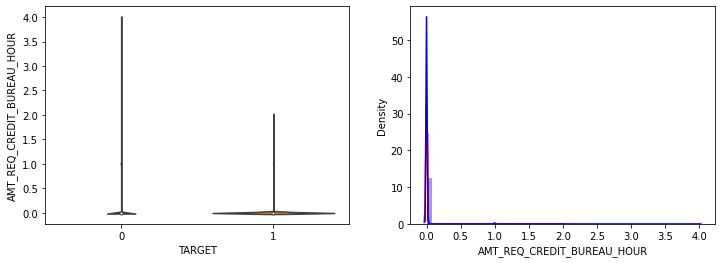

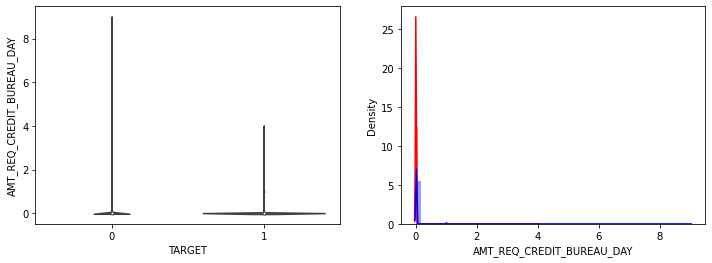

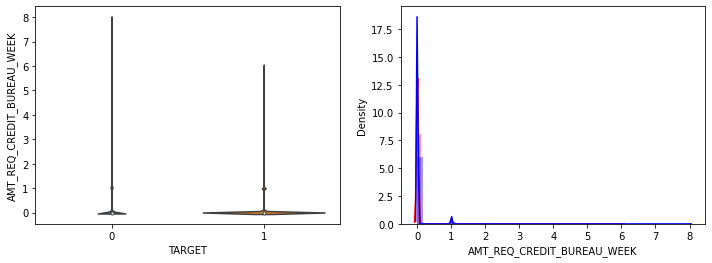

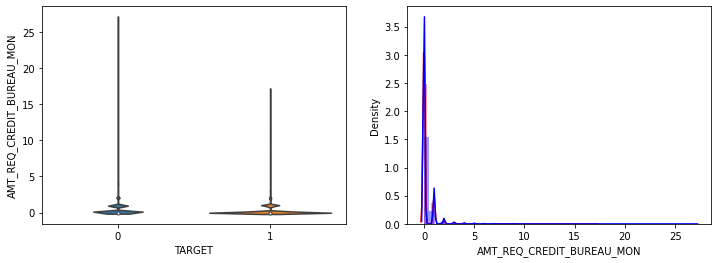

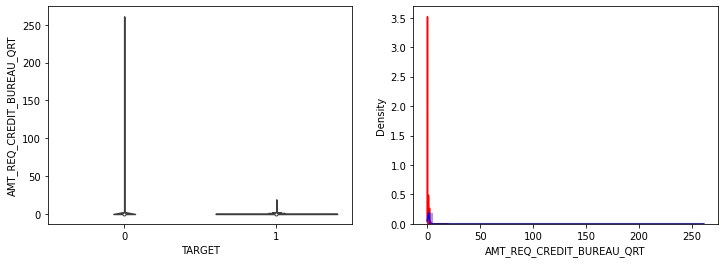

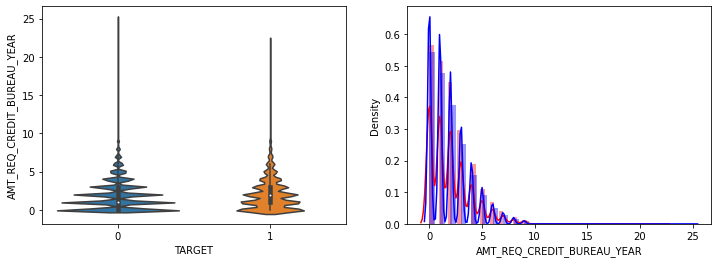

In [79]:
show_hist_by_target(app_train, columns)

* AMT_INCOME_TOTAL, AMT_CREDIT 은 크게 차이가 없음.
* AMT_ANNUITY는 TARGET=1 일 경우 상대적으로 작은 숫자대의 값이 조금 많음
* AMT_GOOD_PRICE는 크게 차이 없음
* DAYS_BIRTH는 TARGET=1일 경우 적은 연령대의 숫자값이 상대적으로 많음.
* DAYS_EMPLOYED는 TARGET=1일 경우 작은 값들이 조금 더 많음.
* DAYS_ID_PUBLISH, DAYS_REGISTRATIOn 은 TARGET=1 일 경우 최근 값들이 조금 더 많음.
* DAYS_LAST_PHONE_CHANGE는 큰 차이 없음.
* CNT_FAM_MEMBERS는 차이가 없음. outlier 때문에 histogram에 차이가 있어보임
* REGION_RATING_CLIENT 는 큰 차이 없음
* EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3 모두 조금씩 차이가 있음.
* 나머지 컬럼은 유의미한 차이가 없음
* 요약 : 연령대가 낮고 직장 경력이 적은, 소액 대출에서 상대적으로 연체 비중이 높다.

seaborn의 countplot() 또는 catplot()을 이용하여 category 피져(object 컬럼)을 TARGET 유형에 따라 Count 비교

In [4]:
object_columns = app_train.dtypes[app_train.dtypes == 'object'].index.tolist()

In [10]:
def show_count_by_target(df, columns):
    cond_0 = (df['TARGET'] == 0)
    cond_1 = (df['TARGET'] == 1)
    
    for column in columns:
        fig, axs = plt.subplots(figsize=(12, 4), nrows=1, ncols=2, squeeze=False)
        sns.countplot(df[cond_0][column], ax=axs[0][0])
        sns.countplot(df[cond_1][column], ax=axs[0][1])

In [ ]:
show_count_by_target(app_train, object_columns)

In [ ]:
def show_category_by_target(df, columns):
    for column in columns:
        print('column name: ', column)
        sns.catplot(x = )